In [1]:
import pandas as pd
import numpy as np
from typing import Optional, Final
import seaborn as sea

In [ ]:
data = pd.read_excel("статистика_старт.xlsx")
data

In [3]:
features: tuple[str] = ("Регион",
                        "Доходы гостиниц и аналогичных средств размещения",
                        "Число гостиниц и средств размещения",
                        "Численность размещенных лиц в гостиницах и ананлогичных средствах размещения",
                        "Число ночевок в гостиницах и ананлогичных средствах размещения",
                        "Средняя численность работников, включая внешних совместителей",
                        "Число туристских фирм",
                        "Средства, поступившие от реализации туристкого продукта",
                        "Число реализованных турпакетов населению",
                        "Индекс стоимости жизни",
                        "Год")
years: Final[list[int]] = list(range(2002, 2020))
years.pop(1)

2003

Собираем все упоминаемые названия регионов

In [ ]:
regions: set[str] = set()
mess: list[str] = data["Unnamed: 0"].fillna("").to_list()
mess.append("")
print(mess)

In [ ]:
def remove_numbers(string: str) -> str:
    if string[0].isdigit():
        space_position: int = string.find(" ")
        string = string[space_position + 1:]
    return string

features_positions: list[int] = list()
i: int = 0
string = mess[i]
while string != features[-2]: 
    if string == "":
        i += 1
        string = mess[i]
        continue
    if string in features:
        features_positions.append(i)
        i += 1
        string = mess[i]
        while string != "":
            regions.add(remove_numbers(string.strip()))
            i += 1
            string = mess[i]
features_positions.append(i)
regions = sorted(list(regions))
print(*enumerate(regions), sep="\n")

In [ ]:
new_data: pd.DataFrame = pd.DataFrame(data=np.full((len(regions) * len(years), len(features)), None), columns=features)
for i in range(len(regions)):
    for j, year in enumerate(years):
        new_data.iloc[i * len(years) + j].iloc[0] = regions[i]
        new_data.iloc[i * len(years) + j].loc["Год"] = year
new_data.set_index(["Регион", "Год"], inplace=True)

new_data

In [ ]:
cities = set()
i += 1
string = mess[i]
while string != "":
    cities.add(remove_numbers(string.strip()))
    i += 1
    string = mess[i]

cities

In [8]:
cities_to_regions: dict[str, Optional[str]] = {"Абакан": regions[10],
                                               "Барнаул": regions[1],
                                               "Горно-Алтайск": regions[7],
                                               "Иркутск": regions[3],
                                               "Кемерово": None, # Кемеровская область не упоминается
                                               "Красноярск": regions[4],
                                               "Кызыл": regions[9],
                                               "Новосибирск": regions[5],
                                               "Омск": regions[6],
                                               "Северобайкальск": regions[8],
                                               "Томск": regions[12],
                                               "Тюмень": regions[13],
                                               "Улан-Удэ": regions[8],
                                               "Ханты-Мансийск": regions[15],
                                               "Юрга": None # Кемеровская область не упоминается
                                               }

In [ ]:
'''ities_to_regions: dict[str, dict[str]] = {regions[10]: {"Абакан"},
                                           regions[1]: {"Барнаул"},
                                           regions[7]: {"Горно-Алтайск"},
                                           regions[3]: {"Иркутск"},
                                           regions[4]: {"Красноярск"},
                                           regions[9]: {"Кызыл"},
                                           regions[5]: {"Новосибирск"},
                                           regions[6]: {"Омск"},
                                           regions[8]: {"Северобайкальск", "Улан-Удэ"},
                                           regions[12]: {"Томск"},
                                           regions[13]: {"Тюмень"},
                                           regions[15]: {"Ханты-Мансийск"},
                                           regions[0]: {},
                                           regions[2]: {},
                                           regions[11]: {},
                                           regions[14]: {},
                                           regions[16]: {},
                                           regions[17]: {}
                                           }'''

In [ ]:
for feature_index, position in enumerate(features_positions[:-1]):
    position += 1
    string = mess[position].strip()
    while string != "":
        region = remove_numbers(string)
        feature = features[feature_index + 1]
        for i, year in enumerate(years, start=1):
            new_data.loc[(region, year), feature] = data.iloc[position].iat[i]
        position += 1
        string = mess[position].strip()

new_data

In [ ]:
cities_data = data.iloc[-len(cities):,:]
cities_data.fillna(0)


In [ ]:
for _, row in cities_data.iterrows():
    city = remove_numbers(row.iloc[0].strip())
    for i, item in enumerate(row):
        regions = cities_to_regions[city]
        if region != None:
            for j, year in enumerate(years, start=1):
                new_data.loc[(region, year), features[-2]] = row.iat[j]

new_data

In [ ]:
new_data = new_data.applymap(lambda x: 0 if str(x).strip() == "" else x, na_action="ignore")

for column in new_data.columns:
    mean: float = new_data.loc[:, column].mean()
    new_data.loc[:, column].fillna(mean, inplace=True)

new_data

In [ ]:
sea.heatmap(new_data.corr());

In [ ]:
new_data.drop(["Индекс стоимости жизни", "Число ночевок в гостиницах и ананлогичных средствах размещения"], axis="columns", inplace=True)
new_data

In [ ]:
sea.heatmap(new_data.corr());

In [17]:
import sklearn.model_selection as model
import sklearn.linear_model as linear
import sklearn.metrics as metrics
import sklearn.preprocessing as preprocessing

In [ ]:
new_data.reset_index(inplace=True)
new_data = pd.get_dummies(data=new_data, columns=["Регион"])
new_data

In [19]:
X: np.ndarray = new_data.drop(["Средняя численность работников, включая внешних совместителей", "Год"], axis="columns").to_numpy()
Y: np.ndarray = new_data.loc[:, "Средняя численность работников, включая внешних совместителей"].to_numpy()

In [20]:
polynom = preprocessing.PolynomialFeatures(1)
X = polynom.fit_transform(X)
X_train, X_test, Y_train, Y_test = model.train_test_split(X, Y, test_size=0.1, shuffle=True, random_state=14)

In [21]:
linear_model = model.GridSearchCV(linear.Ridge(), {"alpha": np.arange(0.05, 1, 0.01)}, cv=2).fit(X_train, Y_train)

In [22]:
prediction: np.ndarray = linear_model.predict(X_test)
prediction

array([605.53531026,  71.82173895, 174.73205234,  71.82173895,
       106.2001435 ,  81.60599112, 198.72395091, 119.54222725,
       119.54222725, 544.11878577,  71.82173895, 377.81406406,
       -20.14186295,  80.22841036, 356.51403324, 686.22378479,
        37.68000618, 457.71319064, 120.82694703, 562.77472449,
        84.592233  , 997.36897329, 160.57676501,  71.82173895,
        80.22841036, 289.50657103, 829.01984637, 206.86475253,
       119.54222725, 298.28229115, 558.84022764])

In [23]:
print(metrics.mean_absolute_error(Y_test, prediction))
print(metrics.r2_score(Y_test, prediction))

112.57983148080089
0.7768518431584119


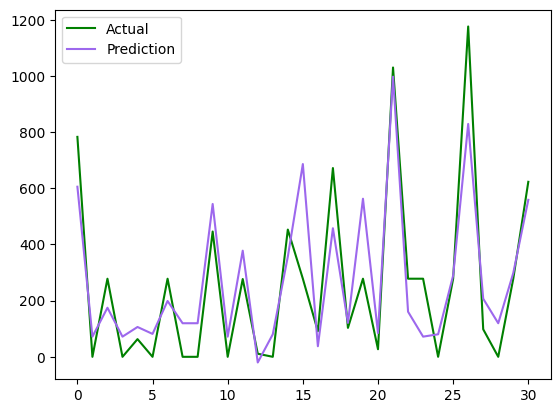

In [24]:
import matplotlib.pyplot as plt

plt.plot(Y_test, label="Actual", color="green");
plt.plot(prediction, label="Prediction", color="#9d68ed");
plt.legend();

# Альтернативные модели

In [25]:
import sklearn.ensemble as ens

boosting_model = ens.GradientBoostingRegressor().fit(X_train, Y_train)

In [26]:
boosting_prediction = boosting_model.predict(X_test)

In [27]:
print(metrics.mean_absolute_error(Y_test, boosting_prediction))
print(metrics.r2_score(Y_test, boosting_prediction))

90.7491815916962
0.7952693414033634


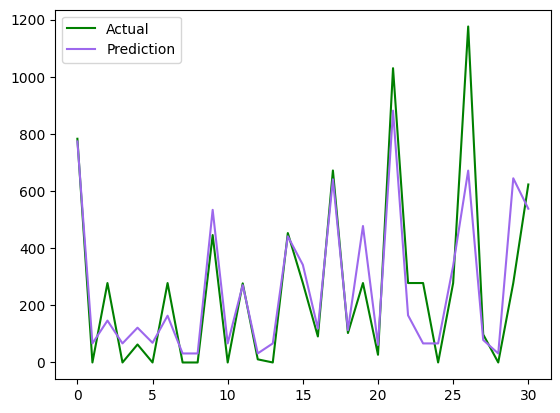

In [28]:
plt.plot(Y_test, label="Actual", color="green");
plt.plot(boosting_prediction, label="Prediction", color="#9d68ed");
plt.legend();

In [29]:
import xgboost as xgb

xgb_model = model.RandomizedSearchCV(xgb.XGBRegressor(), {"max_depth": np.arange(2, 5, 1), "n_estimators": np.arange(1, 10, 1)}, cv=2).fit(X_train, Y_train)
xgb_model.best_params_

{'n_estimators': 9, 'max_depth': 3}

In [30]:
xgb_prediction = xgb_model.predict(X_test)

In [31]:
print(metrics.mean_absolute_error(Y_test, xgb_prediction))
print(metrics.r2_score(Y_test, xgb_prediction))

89.54751232118821
0.8560549809643458


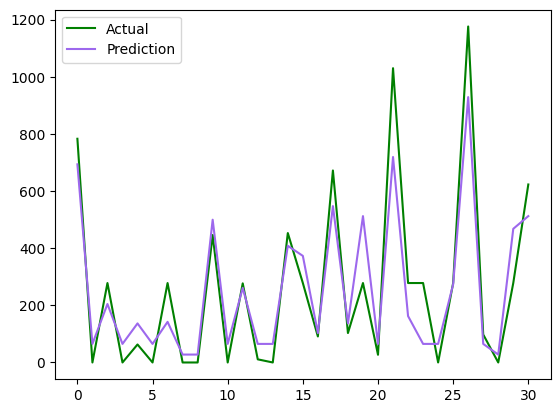

In [32]:
plt.plot(Y_test, label="Actual", color="green");
plt.plot(xgb_prediction, label="Prediction", color="#9d68ed");
plt.legend();